In [7]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('plots/paper.mplstyle')

import seaborn as sns

from scipy.optimize import curve_fit

#https://docs.scipy.org/doc/scipy/reference/odr.html

def second_order_pol(x, p1, p2, p3):
    return p1*x**2 + p2*x + p3

In [8]:
res = pd.read_csv("results/2022_05_all_runs.csv")
# exclude the lowest frequency bin
res.head()

,tstamp,nspots,hem,nflares,color
0,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00
1,2022_03_29_10_44_2022_03_29_09_43,1,bi-hem.,20-40,#E69F00
2,2022_03_30_20_42_2022_03_30_20_25,1,bi-hem.,17-28,#E69F00
3,2022_03_24_15_52_2022_03_24_15_18,1,bi-hem.,10-20,#E69F00
4,2022_03_30_21_00_2022_03_30_20_44,1,bi-hem.,8-15,#E69F00


In [9]:
ms = pd.read_csv("results/2022_05_all_mean_stds.csv")
ms.c.unique()

array(['#E69F00', '#CC79A7', '#230072B2', '#56B4E9', '#009E73'],
      dtype=object)

In [41]:
ms.head()

,tstamp,nspots,hem,nflares,c,latitude,mean_of_wtd_means,mean_of_wtd_stds,std_of_wtd_means,std__of_wtd_stds
0,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,10,0.040497,0.081001,0.000835,0.003024
1,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,15,0.039797,0.077973,0.001158,0.003971
2,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,20,0.038758,0.073823,0.000902,0.003553
3,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,25,0.038176,0.071557,0.000793,0.003376
4,2022_03_30_20_21_2022_03_30_19_47,1,bi-hem.,40-60,#E69F00,30,0.037400,0.068220,0.001189,0.004528


(0.15, 0.25)

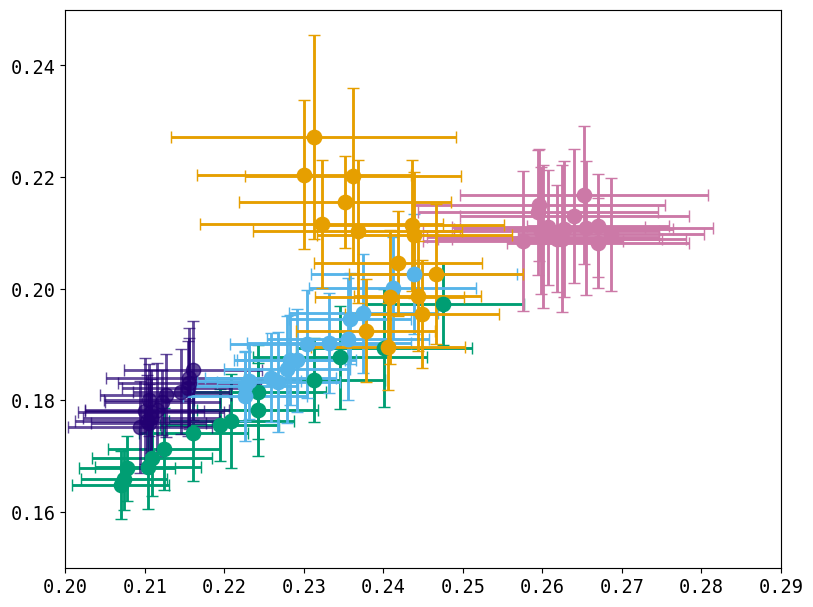

In [57]:
plt.figure(figsize=(8,6))
for c, m in ms.groupby("c"):
    plt.errorbar(m.mean_of_wtd_means, m.mean_of_wtd_stds, xerr=m.std_of_wtd_means, 
                 yerr=m.std__of_wtd_stds,fmt="o",markersize=10,c=c,capsize=4)
plt.xlim(0.2,0.29)
plt.ylim(.15,.25)

In [10]:
from scipy.odr import Model, RealData, ODR

In [29]:

def fourth_order_pol(x, p1, p2, p3, p4, p5):
    return p1*x**4 + p2*x**3 + p3*x**2 + p4*x + p5

def second_order_pol(x, p1, p2, p3):
    return p1*x**2 + p2*x + p3

def polyfit(b0,x):
    mean, sigma = x
    a1,a2,a3,a4,a5, b1,b2, b3 = b0
    return fourth_order_pol(mean,a1,a2,a3,a4,a5) * sigma + second_order_pol(mean, b1,b2, b3)

def polyfit_err(b0,x):
    mean, sigma = x
    a1,a2,a3,a4,a5, b1,b2, b3 = b0
    return fourth_order_pol(mean,a1,a2,a3,a4,a5) * sigma + second_order_pol(mean, b1,b2, b3)


def latfit1spot(b0,x):
#     print(x, b0)
    mu, sig = x
    a,b,c,d,e = b0
    return a *  mu**2 + b * mu + c * sig + d +  e *  sig * mu

def latfit1spot_err(b0err, x):
    mu, sig = x
#     a,b,c,d, e = b0
    ar,br,cr,dr,er = b0err# 
    return np.sqrt((mu**2 * ar)**2 + (br * mu)**2 + (cr * sig)**2 + dr**2 + (er *  sig * mu)**2)

def latfit(b0,x):
#     print(x, b0)
    mu, sig = x
    a,b,c,d,e = b0
    return  a *  mu**2 + b * mu + c * sig + d +  e * sig*mu #  + f * sig * mu**2 +

def latfit_err(b0err, x):
    mu, sig = x
#     a,b,c,d, e = b0
    ar,br,cr,dr,er= b0err # (sig * mu * er)**2 + (sig * mu**2 * fr)**2
    return np.sqrt( + (mu**2 * ar)**2 + (br * mu)**2 + (cr * sig)**2 + dr**2 + (sig* mu * er)**2)

Beta: [-2404.69027992  1710.01135568 -1677.3040046     83.91227787
   742.67825813]
Beta Std Error: [243.14102596  26.99150613  31.54569271   1.41409937 338.23154485]
Beta Covariance: [[ 6.88026642e+05 -3.23049013e+04  7.49318586e+04 -2.10721288e+03
  -8.99251066e+05]
 [-3.23049013e+04  8.47896814e+03 -4.85588299e+03 -7.39583223e+01
   1.49189814e+04]
 [ 7.49318586e+04 -4.85588299e+03  1.15816091e+04 -3.85503761e+02
  -1.04229236e+05]
 [-2.10721288e+03 -7.39583223e+01 -3.85503761e+02  2.32727991e+01
   4.06185201e+03]
 [-8.99251066e+05  1.49189814e+04 -1.04229236e+05  4.06185201e+03
   1.33142585e+06]]
Residual Variance: 0.08592335663579599
Inverse Condition #: 0.006523730374482806
Reason(s) for Halting:
  Sum of squares convergence
None
Beta: [ -172.97856699  3751.82956148 -2816.64354724    46.22260606
 -6738.89155396]
Beta Std Error: [589.47030485  56.40176386  67.8092971    2.08358615 835.63109617]
Beta Covariance: [[ 9.95052271e+06 -2.90747871e+05  9.63075221e+05 -2.56216374e+04
  

/tmp/ipykernel_4563/2522703483.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["minflares"]=mono.nflares.apply(lambda x: float(x.split("-")[0]))
/tmp/ipykernel_4563/2522703483.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["maxflares"]=mono.nflares.apply(lambda x: float(x.split("-")[-1]))
/tmp/ipykernel_4563/2522703483.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Beta: [-11601.4507571   15411.72913408 -11819.37001316    -73.19766489
 -13130.47288333]
Beta Std Error: [2620.84301679  359.7279926   314.75551293    4.26475083 3344.16759429]
Beta Covariance: [[ 3.66595604e+08 -1.57474557e+07  2.72367649e+07 -2.96950595e+05
  -4.56852459e+08]
 [-1.57474557e+07  6.90643144e+06 -5.58819393e+06 -4.61557277e+04
   7.36855741e+06]
 [ 2.72367649e+07 -5.58819393e+06  5.28751883e+06  1.52171292e+04
  -2.58873522e+07]
 [-2.96950595e+05 -4.61557277e+04  1.52171292e+04  9.70716834e+02
   5.06526293e+05]
 [-4.56852459e+08  7.36855741e+06 -2.58873522e+07  5.06526293e+05
   5.96872135e+08]]
Residual Variance: 0.018736771636049063
Inverse Condition #: 0.002198558483426021
Reason(s) for Halting:
  Sum of squares convergence
None


/tmp/ipykernel_4563/2522703483.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["minflares"]=mono.nflares.apply(lambda x: float(x.split("-")[0]))
/tmp/ipykernel_4563/2522703483.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["maxflares"]=mono.nflares.apply(lambda x: float(x.split("-")[-1]))


Beta: [-2732.97134489  5264.58748596 -3889.29199256    26.01916104
 -7163.88541931]
Beta Std Error: [ 917.11031538   99.49812692   96.93146783    2.10203071 1250.16958211]
Beta Covariance: [[ 1.94948612e+07 -6.86552326e+05  1.60906869e+06 -2.77444879e+04
  -2.58851034e+07]
 [-6.86552326e+05  2.29459901e+05 -1.73617874e+05 -1.51329722e+03
   3.74207903e+05]
 [ 1.60906869e+06 -1.73617874e+05  2.17774272e+05 -1.59892867e+03
  -1.91494223e+06]
 [-2.77444879e+04 -1.51329722e+03 -1.59892867e+03  1.02413004e+02
   4.64338873e+04]
 [-2.58851034e+07  3.74207903e+05 -1.91494223e+06  4.64338873e+04
   3.62255383e+07]]
Residual Variance: 0.043144258419291336
Inverse Condition #: 0.003551707842318328
Reason(s) for Halting:
  Sum of squares convergence
None
Beta: [-16704.15983986   9983.7602554   -8552.11749234    -28.04843424
   4991.994512  ]
Beta Std Error: [1389.31637916  203.35290292  187.7059588     2.57914079 1803.03750836]
Beta Covariance: [[ 4.88757437e+07 -3.15755951e+06  4.48995157e+06 -1

/tmp/ipykernel_4563/2522703483.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["minflares"]=mono.nflares.apply(lambda x: float(x.split("-")[0]))
/tmp/ipykernel_4563/2522703483.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["maxflares"]=mono.nflares.apply(lambda x: float(x.split("-")[-1]))
/tmp/ipykernel_4563/2522703483.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

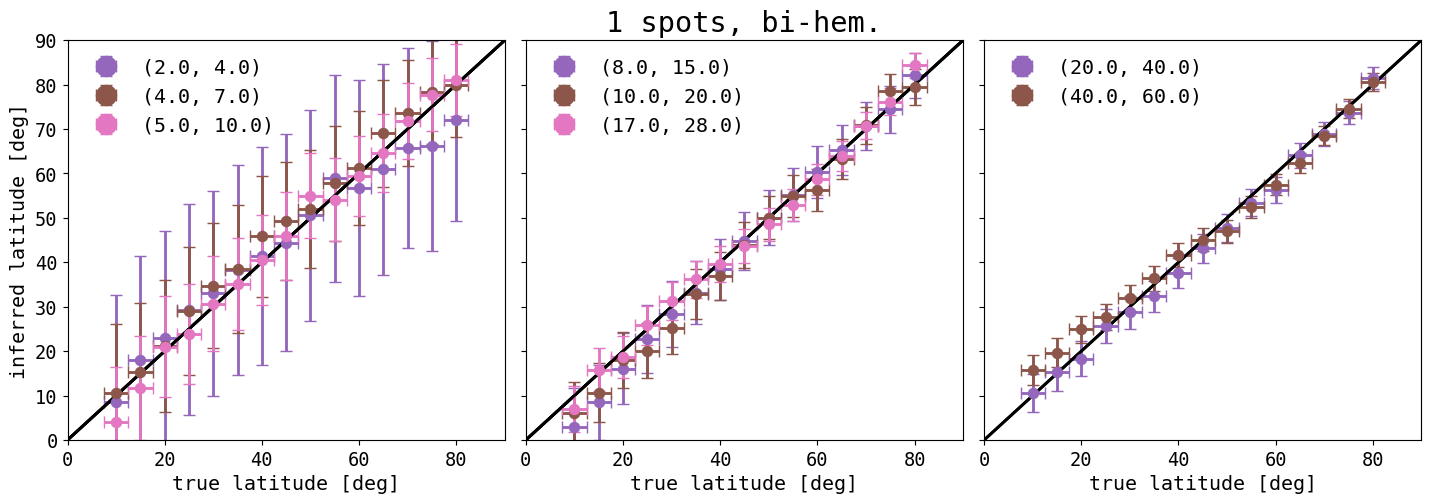

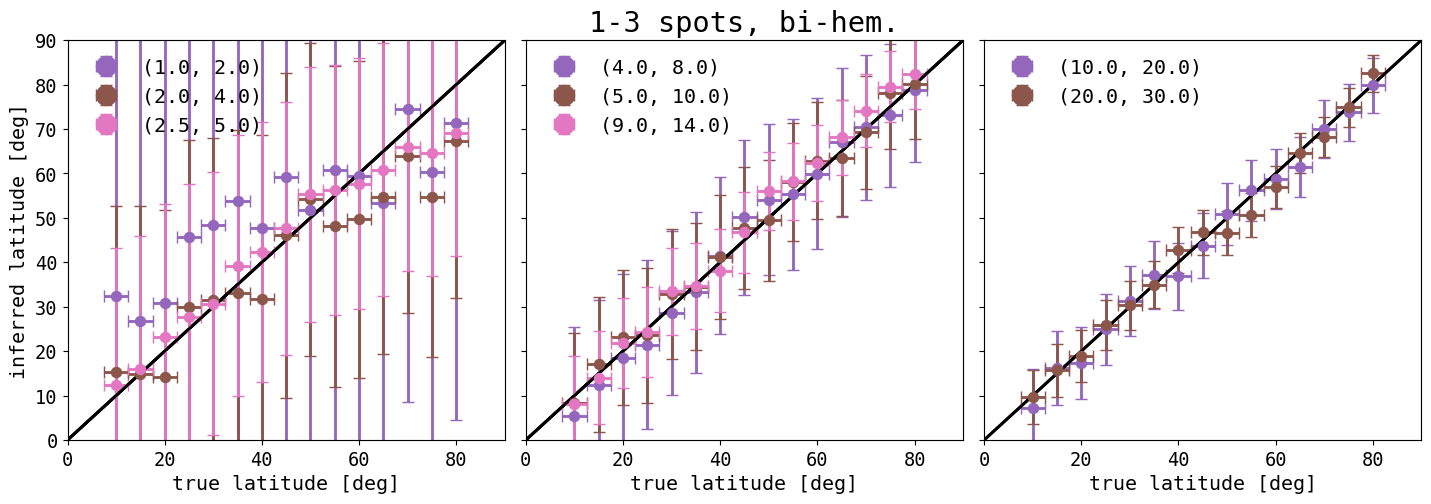

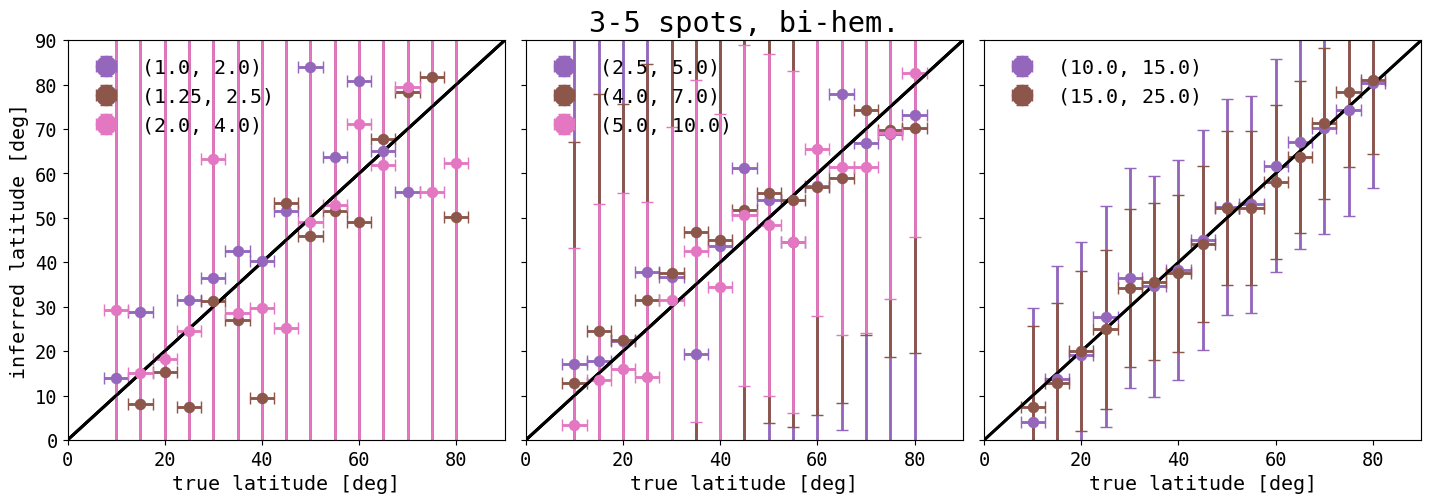

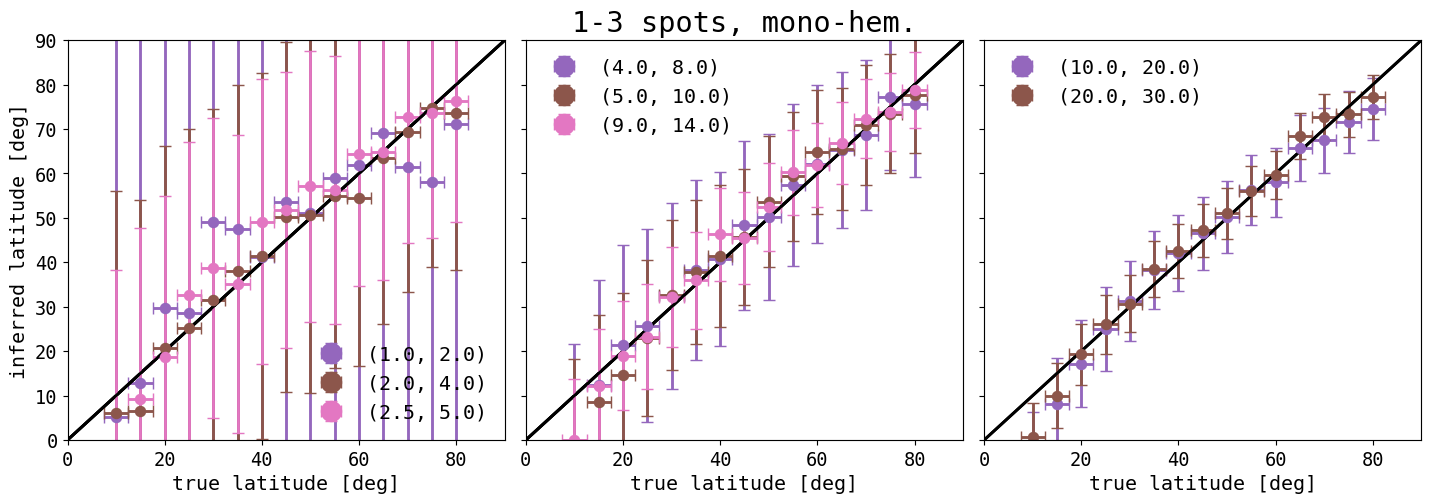

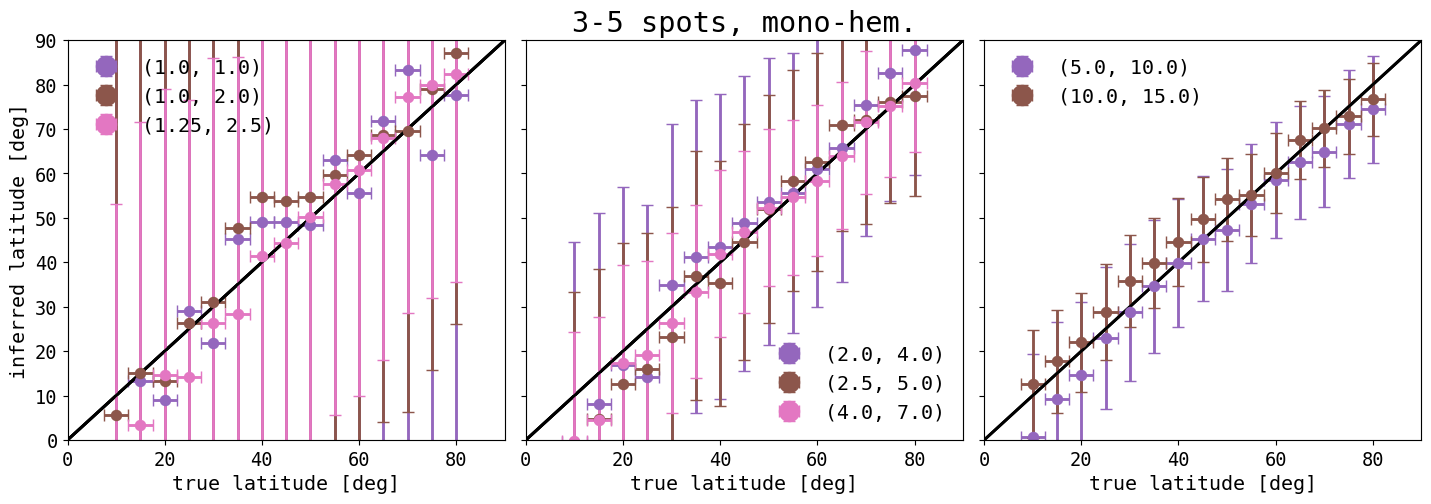

In [35]:
fitres = {}
for color in ms.c.unique()[:]:
    mono= ms[ms.c == color]
    tt = f"{mono.nspots.iloc[0]} spots, {mono.hem.iloc[0]}"
    fitres[tt]={}
    f = Model(latfit1spot)
    x = np.array([mono.mean_of_wtd_means.values,mono.mean_of_wtd_stds.values])
    y = mono.latitude.values
    sx = np.array([mono.std_of_wtd_means.values,mono.std__of_wtd_stds.values])
    sy = np.full_like(y,2.5)
    mydata = RealData(x, y, sx=sx, sy=sy)

    myodr = ODR(mydata, f, 
                beta0=[-1788.8766187 ,  1627.4705935 , -1562.95810747,    81.56885256,3390.18811414,],
#                      -1562.95810747,    81.56885256,3390.18811414,],
                maxit=5000)
    fitres[tt]={}
    myoutput = myodr.run()
    print(myoutput.pprint())
    mono["minflares"]=mono.nflares.apply(lambda x: float(x.split("-")[0]))
    mono["maxflares"]=mono.nflares.apply(lambda x: float(x.split("-")[-1]))
    mono = mono.sort_values("minflares",ascending=True)
    fitres[tt]=dict(zip(["a","b","c","d","e","ar","br","cr","dr","er"],
                        np.concatenate((myoutput.beta,myoutput.sd_beta))))

    axes = [0,0,0,1,1,1,2,2]
    fig, AX = plt.subplots(nrows=1, ncols=3, figsize=(14,5),sharey=True)
    for ax, (label, g) in list(zip(axes,mono.groupby(["minflares","maxflares"]))):
#         print(label)
        x = np.array([g.mean_of_wtd_means.values,g.mean_of_wtd_stds.values])
        y = g.latitude.values
        AX[ax].errorbar(y,latfit1spot(myoutput.beta,x),xerr=2.5,yerr=latfit1spot_err(myoutput.sd_beta,x),
                     label=label,fmt="o",markersize=7, alpha=1,capsize=4)
        AX[ax].plot([0,90],[0,90],c="k")
        AX[ax].set_xlim(0,90)
        AX[ax].set_ylim(0,90)
        AX[ax].set_xlabel("true latitude [deg]")
        AX[ax].legend();
    AX[0].set_ylabel("inferred latitude [deg]")
    AX[1].set_title(f"{mono.nspots.iloc[0]} spots, {mono.hem.iloc[0]}",fontsize=20)
    plt.tight_layout()
#     plt.savefig(f"plots/{mono.nspots.iloc[0]}_spots_{mono.hem.iloc[0]}_fit_5params".replace("-","_").replace(".",""),dpi=300)

In [36]:
fitresd = pd.DataFrame(fitres)
fitresd

,"1 spots, bi-hem.","1-3 spots, bi-hem.","3-5 spots, bi-hem.","1-3 spots, mono-hem.","3-5 spots, mono-hem."
a,-2404.690280,-172.978567,-11601.450757,-2732.971345,-16704.159840
b,1710.011356,3751.829561,15411.729134,5264.587486,9983.760255
c,-1677.304005,-2816.643547,-11819.370013,-3889.291993,-8552.117492
d,83.912278,46.222606,-73.197665,26.019161,-28.048434
e,742.678258,-6738.891554,-13130.472883,-7163.885419,4991.994512
ar,243.141026,589.470305,2620.843017,917.110315,1389.316379
br,26.991506,56.401764,359.727993,99.498127,203.352903
cr,31.545693,67.809297,314.755513,96.931468,187.705959
dr,1.414099,2.083586,4.264751,2.102031,2.579141
er,338.231545,835.631096,3344.167594,1250.169582,1803.037508


<Figure size 824x515 with 0 Axes>

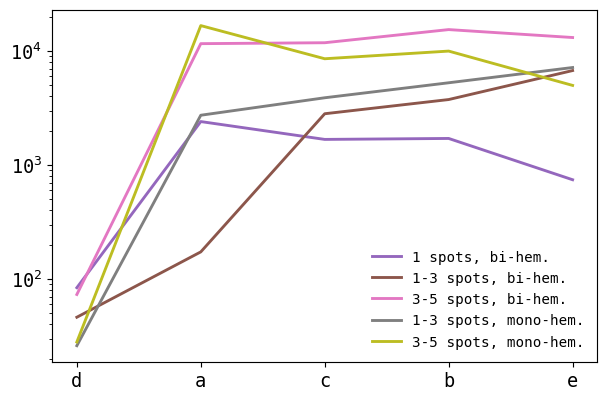

In [37]:
plt.figure(figsize=(8,5))
fitresd.iloc[:5].abs().sort_values("1-3 spots, bi-hem.").plot()
plt.yscale("log")
plt.legend(fontsize=10)

In [40]:
testmean, teststd = 0.07, 0.06
for rows in fitresd:
    fitresd[row]

1 spots, bi-hem.
1-3 spots, bi-hem.
3-5 spots, bi-hem.
1-3 spots, mono-hem.
3-5 spots, mono-hem.


In [155]:
np.dot(myoutput.cov_beta , myoutput.beta.T)

array([-2.50344727e+09,  1.11401003e+08, -2.85358543e+08,  8.60593382e+06,
        3.35191791e+09])

In [157]:
pd.DataFrame(myoutput.cov_beta/1e6)

,0,1,2,3,4
0,0.688027,-0.032305,0.074932,-0.002107,-0.899251
1,-0.032305,0.008479,-0.004856,-0.000074,0.014919
2,0.074932,-0.004856,0.011582,-0.000386,-0.104229
3,-0.002107,-0.000074,-0.000386,0.000023,0.004062
4,-0.899251,0.014919,-0.104229,0.004062,1.331426


# Fixed mean

In [ ]:
plt.figure(figsize=(7.5,6))
def powerlaw(x,a,b,c):
    return a*x**b +c

def neg_powerlaw(x,a,b,c):
    return (-a)*x**b +c

fits = {}
i=0
for c, g in ms.groupby("c"):
    fits[c] = {}
    for lat, h in g.groupby("latitude"):
#     g["stdomean"]= g.mean_of_wtd_stds
#     g = g.sort_values("stdomean",ascending=True)
        fits[c][lat] = {}
        minmean, maxmean = h.mean_of_wtd_stds.min(), h.mean_of_wtd_stds.max()
        plt.scatter(h.mean_of_wtd_stds, h.mean_of_wtd_means+i,c=c,label=lat,s=30)
        resul = curve_fit(powerlaw, h.mean_of_wtd_stds,h.mean_of_wtd_means)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        fits[c][lat]["minmean"] = minmean
        fits[c][lat]["maxmean"] = maxmean
        x = np.linspace(minmean, maxmean,25)
        plt.plot(x, powerlaw(x, *resul)+i,c="k",linewidth=0.5)
        i += 0.00
plt.xlabel("std WTD [rotation period]")
plt.ylabel("mean WTD [rotation period]")
# plt.legend()
# plt.xlim(0.04,0.2)
# plt.ylim(0.03,0.22)
# plt.xscale("log")
# plt.yscale("log")

In [ ]:
# extrapolate the equi-latitude lines to allow us to switch axes

fits = {}
for c, mono in ms.groupby("c"):
    fits[c] = {}
    for lat, h in mono.groupby("latitude"):
        fits[c][lat] = {}
        resul = curve_fit(powerlaw,h.mean_of_wtd_stds,h.mean_of_wtd_means)[0]
        minmean, maxmean = h.mean_of_wtd_stds.min(), h.mean_of_wtd_stds.max()
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        fits[c][lat]["minmean"] = minmean
        fits[c][lat]["maxmean"] = maxmean
        
reform = {(outerKey, innerKey): values for outerKey, innerDict in fits.items() for innerKey, values in innerDict.items()}        
df = pd.DataFrame(reform).T


In [ ]:
df = df.reset_index().set_index("level_1").rename(index=str, columns={"level_0":"color"})
df

In [ ]:
# switch axes
dd = {}
for color, g in df.groupby("color"):
    dd[color] = {}
    for mean in np.linspace(0.02,0.25, 30):
        dd[color][mean] = {}
        for i, row in g.iterrows():
            if (mean > (row.minmean-0.005)) & (mean < row.maxmean+0.005):
                std = powerlaw(mean, row.a,row.b,row.c)
                dd[color][mean][i]= std

reform = {(outerKey, innerKey): values for outerKey, innerDict in dd.items() for innerKey, values in innerDict.items()}        
ddd = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_1":"mean","level_0":"color"})
ddd = ddd.set_index("mean")

ddd

In [ ]:
ddd = ddd.reindex(sorted(ddd.columns), axis=1)
ddd

In [ ]:
def third_order_pol(x, a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d
def first_order_pol(x, a,b):
    return a*x - b
def fourth_order_pol(x, a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x +e
def sinfunc(x, a,b,c):
    return np.cos(a*x - b) + c
def neg_expfunc(x, a,b,c):
    return a + (-b) * np.exp(x*(-c))
def expfunc(x, a,b,c):
    return a + b * np.exp(x*c)

fig, ax = plt.subplots(figsize=(9,5))
latstd = {}
for c, g in ddd.groupby("color"):
    i=0
    latstd[c] = {}
    for mean, row in g.iterrows():
        
        x = row.values[:-1].astype(float)
        y = row.index.values[:-1].astype(float)
        y = y[~np.isnan(x)]
        x = x[~np.isnan(x)]
#         print(y.shape,x.shape)
        if y.shape[0]>10:
            res = curve_fit(first_order_pol,x,y)[0]
            latstd[c][mean] = dict(zip(["m","c"],res))#"p3","p2",
            if i%5==0:

                ax.plot(x.astype(float), first_order_pol(x,*res),c=c, linewidth=1.7)

                if i == 10:
                    label = f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}"
                    ax.scatter(x,y, c=c, s=30,marker="x",alpha=1,
                             label=label,)
                    if c=="#E69F00":
                        plt.text(x=x[0],y=90,s=fr"$\mu={mean:.2f}$",fontsize=9)
                else:
                    ax.scatter(x,y,  c=c, s=30,marker="x",alpha=1,)
                    if c=="#E69F00":
                        plt.text(x=x[0],y=90,s=fr"$\mu={mean:.2f}$",fontsize=9)
        i += 1
plt.legend(fontsize=10,frameon=False)
plt.xlabel("std waiting time [rot. per.]")
plt.ylabel("latitude [deg]")
plt.title("fixed mean")
plt.ylim(0,100)
# plt.grid();

In [ ]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in latstd.items() for innerKey, values in innerDict.items()}        
latstdd = pd.DataFrame(reform).T

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)

    for axis, col in list(zip(ax[:-1],g.columns.values)):
        axis.scatter(g.index.values, g[col].values,c=c,s=30,
                     label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

        axis.set_ylabel(col)
        axis.set_xlabel("mean waiting time [rot. per.]")
        axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#         axis.set_yscale("log")
#         axis.set_xscale("log")

for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    ax[-1].scatter(g.index.values, (g["m"]/g["c"]).values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    ax[-1].set_ylabel(r"$m/c$")
    ax[-1].set_xlabel("mean waiting time [rot. per.]")
#     ax[-1].set_yscale("log")
    ax[-1].set_title(fr"$\theta = m \cdot \sigma - c$")

plt.tight_layout()
ax[-1].legend(frameon=False,fontsize=11)
# ax[1].set_ylim(-170,-25)
# ax[0].set_ylim(0,2000)

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    axis.scatter(g.index.values, (g["m"]/g["c"]).values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    axis.set_ylabel(r"$m/c$")
    axis.set_xlabel("mean waiting time [rot. per.]")
#     axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#     axis.set_yscale("log")
#         axis.set_xscale("log")
plt.tight_layout()
axis.legend(frameon=False,fontsize=11)

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
for c, g in latstdd.groupby(level=0):
#     if c !="#230072B2":
    g = g.reset_index(level=0).drop("level_0",axis=1)


    axis.scatter(g["m"].values, g["c"].values,c=c,s=30,
                 label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")

    axis.set_xlabel(r"$m$")
    axis.set_ylabel(r"$c$")
#     axis.set_title(fr"$\theta = m \cdot \sigma - c$")
#     axis.set_yscale("log")
#         axis.set_xscale("log")
plt.tight_layout()
axis.legend(frameon=False,fontsize=11)

In [ ]:
for c, g in latstdd.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,4))

    for axis, col in list(zip(ax,g.columns.values)):
        axis.scatter(g.index.values, g[col].values,s=30)
#         axis.set_xlim(0.06,0.2)
        axis.set_ylabel(col)
        axis.set_xlabel("mean waiting time [rot. per.]")
    ax[1].set_title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")
    plt.tight_layout()

In [ ]:

reform = {(outerKey, innerKey): values for outerKey, innerDict in latstd.items() for innerKey, values in innerDict.items()}        
latstdd = pd.DataFrame(reform).T

for c, g in latstdd.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    g.plot()
    plt.xlabel("mean waiting time [rot. per.]")
    plt.title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")


# Fixed STD

In [ ]:
plt.figure(figsize=(7.5,6))
def powerlaw(x,a,b,c):
    return a*x**b +c

fits = {}
i=0
for c, g in ms.groupby("c"):
    fits[c] = {}
    for lat, h in g.groupby("latitude"):
#     g["stdomean"]= g.mean_of_wtd_stds
#     g = g.sort_values("stdomean",ascending=True)
        fits[c][lat] = {}
        plt.scatter(h.mean_of_wtd_means,h.mean_of_wtd_stds+i,c=c,label=lat,s=50)
        resul = curve_fit(powerlaw, h.mean_of_wtd_means, h.mean_of_wtd_stds)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        x = np.linspace(0.03,0.28,25)
        plt.plot(x, powerlaw(x, *resul)+i,c="k")
        i += 0.01
plt.xlabel("mean WTD [rotation period]")
plt.ylabel("std WTD [rotation period]")
# plt.legend()
# plt.xlim(0.04,0.2)
# plt.ylim(0.03,0.22)
# plt.xscale("log")
# plt.yscale("log")

In [ ]:
# extrapolate the equi-latitude lines to allow us to switch axes

fits = {}
for c, mono in ms.groupby("c"):
    fits[c] = {}
    for lat, h in mono.groupby("latitude"):
        fits[c][lat] = {}
        resul = curve_fit(powerlaw, h.mean_of_wtd_means,h.mean_of_wtd_stds)[0]
        fits[c][lat]["a"] = resul[0]
        fits[c][lat]["b"] = resul[1]
        fits[c][lat]["c"] = resul[2]
        
reform = {(outerKey, innerKey): values for outerKey, innerDict in fits.items() for innerKey, values in innerDict.items()}        
df = pd.DataFrame(reform).T
df = df.reset_index().set_index("level_1").rename(index=str, columns={"level_0":"color"})

In [ ]:
# switch axes
dd = {}
for color, g in df.groupby("color"):
    dd[color] = {}
    for std in np.linspace(0.05,0.2, 20):
        dd[color][std] = {}
        for i, row in g.iterrows():
            mean = powerlaw(std, row.a,row.b,row.c)
            dd[color][std][i]= mean

reform = {(outerKey, innerKey): values for outerKey, innerDict in dd.items() for innerKey, values in innerDict.items()}        
ddd = pd.DataFrame(reform).T.reset_index().rename(index=str, columns={"level_1":"std","level_0":"color"})
ddd = ddd.set_index("std")



In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
latmean = {}
for c, g in ddd.groupby("color"):
    i=0
    latmean[c] = {}
    for std, row in g.iterrows():
        latmean[c][std] = dict(zip(["p2","p1","p0"],res))
        x = row.values[1:]
        y = row.index.values[1:].astype(float)

        res = curve_fit(second_order_pol,x,y)[0]
        
        if i%7==0:
            
#             print(x,second_order_pol(x,*res))
            ax.plot(x.astype(float), second_order_pol(x,*res),c="k")
#             ax.scatter(x.astype(float),y.astype(float),c=c)
            if std == 0.05:
                ax.scatter(x,y, c=c, s=30,marker="x",
                         label=f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}", linewidth=1.4)
                if c=="#009E73":
                    plt.text(x=x[-1],y=90,s=f"std={std:.2f}")
            else:
                ax.scatter(x,y,  c=c, s=30,marker="x")
                if c=="#009E73":
                    plt.text(x=x[-1],y=90,s=f"std={std:.2f}")
        i += 1
plt.legend(fontsize=10,frameon=False)
plt.xlabel("mean waiting time [rot. per.]")
plt.ylabel("latitude [deg]")
plt.title("fixed std")
plt.ylim(0,100)
# plt.grid();

In [ ]:

reform = {(outerKey, innerKey): values for outerKey, innerDict in latmean.items() for innerKey, values in innerDict.items()}        
latmeand = pd.DataFrame(reform).T

for c, g in latmeand.groupby(level=0):
    g = g.reset_index(level=0).drop("level_0",axis=1)
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,4))
    g = g.loc[g.index>.05]
    for axis, col in list(zip(ax,g.columns.values)):
        axis.plot(g.index.values, g[col].values)
        axis.set_xlim(0.06,0.2)
        axis.set_ylabel(col)
        axis.set_xlabel("std waiting time [rot. per.]")
    ax[1].set_title(f"{ms[ms.c==c].nspots.iloc[0]},{ms[ms.c==c].hem.iloc[0]}")
    plt.tight_layout()

In [ ]:
latmeand